# Introduction

I'm trying to understand Rafa's QC metrics.

I thought I should try to replicate the correlations for two libraries that did poorly. I'm using ENCSR950BNG from http://wiki.encodedcc.org/index.php/File:Lrna_qc_all.xlsx which is "Total RNA-seq on postnatal 0 day mouse liver (13pgs)"

I downloaded the RSEM Gene quantification TSV files ENCFF923KGS.tsv, ENCFF023RHI.tsv

# Python setup

Skip down to <a href="#How many non zeros"> if you're not a python programmer.

In [1]:
from __future__ import print_function
import pandas
import numpy
import os
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
%load_ext rmagic
#%load_ext rpy2.ipython.
%matplotlib inline

/usr/lib/python3/dist-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [3]:
def load_rsem_reps(name1, name2, column, root=None):
    """Load two RSEM quantifications and and return the two scores as a dataframe.
    """
    if root is None:
        root = os.path.expanduser('~/dl/')

    rep1 = pandas.read_csv(os.path.join(root, name1), sep='\t', index_col=0)
    rep2 = pandas.read_csv(os.path.join(root, name2), sep='\t', index_col=0)
    
    reps = pandas.DataFrame({'rep1': rep1['FPKM'],
                             'rep2': rep2['FPKM']},
                            index=rep1.index)
    return reps

def score_replicates(reps, rep1name, rep2name, filtered):
    if filtered is None:
        rep1 = reps[rep1name]
        rep2 = reps[rep2name]
    else:
        rep1 = filtered[rep1name]
        rep2 = filtered[rep2name]

    scores = pandas.Series({
        'total rows': len(reps),
        'passed filter': len(rep1),
        'Pearson': scipy.stats.pearsonr(rep1, rep2)[0],
        'Spearman': scipy.stats.spearmanr(rep1, rep2)[0]
    },
    index = ['total rows', 'passed filter', 'Pearson', 'Spearman']
    )
    return scores

def plot_cumsum_replicates(rep1, rep2, column):
    """Make side-by-side cumulative sum plot
    """
    f = plt.figure("12", figsize=(10,5))

    plt.subplot("121")
    plt.title("Rep 1")
    plt.ylabel("Cum sum {}".format(column))
    plt.xlabel("datapoints seen")
    plt.plot(numpy.cumsum(sorted(rep1)))

    plt.subplot("122")
    plt.title("Rep 2")
    plt.xlabel("datapoints seen")
    plt.plot(numpy.cumsum(sorted(rep2)))

def plot_spikes(rep1, rep2):
    spikes = [ x.startswith('gSpikein') for x in rep1.index ]
    plt.title('Spikes (n={})'.format(len(rep1[spikes])))
    plt.xlabel('rep 1 $log_2$ filtered')
    plt.ylabel('rep 2 $log_2$ filtered')
    plt.scatter(rep1[spikes], rep2[spikes], c='y')
    
    xlim = plt.xlim()
    xmin, xmax = int(xlim[0]), int(xlim[1])
    plt.plot(range(xmin, xmax), range(xmin, xmax), 'k', label='$y = x$')
    plt.legend()

# Load RSEM Gene Quantifications

In [4]:
store = pandas.HDFStore('comparison.h5', 'r')
tissue_10ng_fpkms = store.get('/tissue_10ng/fpkms')
tissue_10ng_scores = store.get('/tissue_10ng/fpkm_scores')
tissue_10ng_labels = store.get('/tissue_10ng/labels')
tissue_13pg_fpkms = store.get('/tissue_13pg/fpkms')
tissue_13pg_scores = store.get('/tissue_13pg/fpkm_scores')
tissue_13pg_labels = store.get('/tissue_13pg/labels')
store.close()

reps = tissue_13pg_fpkms[['ENCLB356IIP', 'ENCLB791CRT']]
rep1 = 'ENCLB356IIP'
rep2 = 'ENCLB791CRT'

# How many non-zeros

In [5]:
print("rep1 > 0: ", len(reps[rep1][reps[rep1] > 0]))
print("rep2 > 0: ", len(reps[rep2][reps[rep2] > 0]))
print("Total rows:", len(reps[rep1]))

rep1 > 0:  8642
rep2 > 0:  7350
Total rows: 69690


# Scatter plot of raw FPKM values

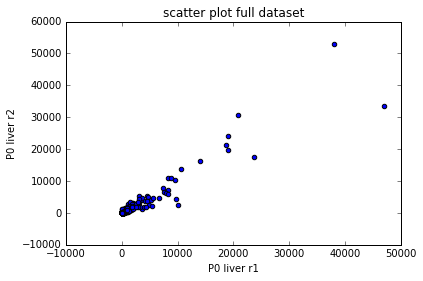

In [6]:
plt.title("scatter plot full dataset")
plt.xlabel(tissue_13pg_labels[rep1])
plt.ylabel(tissue_13pg_labels[rep2])
_ = plt.scatter(reps[rep1], reps[rep2])

Well that was hard to visualize... lets try a smaller view

# Zoomed in scatter plot of raw FPKM values

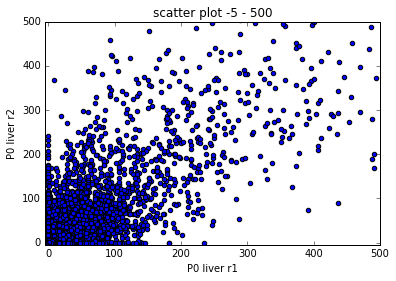

In [7]:
plt.title("scatter plot -5 - 500")
plt.xlim(-5, 500)
plt.ylim(-5, 500)
plt.xlabel(tissue_13pg_labels[rep1])
plt.ylabel(tissue_13pg_labels[rep2])

_ = plt.scatter(reps[rep1], reps[rep2])

# Cumulative sum of sorted FPKM values

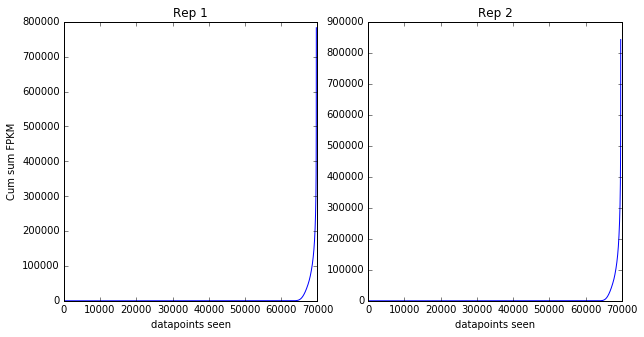

In [8]:
plot_cumsum_replicates(reps[rep1], reps[rep2], 'FPKM')

I was trying to visualize how many zeros and small values we have. This plot is a "sorted cumulative sum". The x axis is the number of data points seen so far, the y axis is the sum of all data points seen so far.

# Naïve Correlation

Compute correlations on the FPKM column, without any transformations. I did not drop zeros, log transform, threshold or do any other manipulation.

In [9]:
naive_scores = score_replicates(reps, rep1, rep2, None)
pandas.DataFrame(naive_scores)

,0
total rows,69690.000000
passed filter,69690.000000
Pearson,0.949737
Spearman,0.655810


# Drop double zeros

Remove rows where both replicates are zero.

In [10]:
bothzero = (reps[rep1] == 0) & (reps[rep2] == 0)
bothzero_reps = reps[bothzero != True]

bothzero_score = score_replicates(reps, rep1, rep2, bothzero_reps)
pandas.DataFrame(bothzero_score)

,0
total rows,69690.000000
passed filter,10601.000000
Pearson,0.949396
Spearman,0.305444


## Scatter plot of log 2 transformed data with double zeros removed

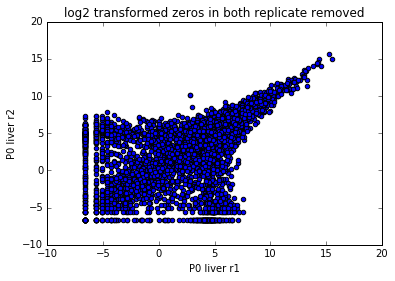

In [11]:
plt.title("log2 transformed zeros in both replicate removed")
plt.xlabel(tissue_13pg_labels[rep1])
plt.ylabel(tissue_13pg_labels[rep2])

_ = plt.scatter(numpy.log2(bothzero_reps[rep1]), 
                numpy.log2(bothzero_reps[rep2]))

## Cumulative sum when double-zeros are dropped

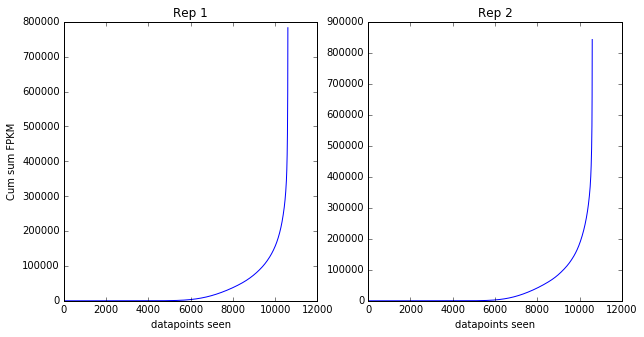

In [12]:
plot_cumsum_replicates(bothzero_reps[rep1], bothzero_reps[rep2], 'FPKM')

# Drop rows where either replicate contains a zero

In [13]:
nozero = (reps[rep1] == 0) | (reps[rep2] == 0)
nozero_reps = reps[nozero != True]

nozero_scores = score_replicates(reps, rep1, rep2, nozero_reps)
pandas.DataFrame(nozero_scores)

,0
total rows,69690.000000
passed filter,5391.000000
Pearson,0.949233
Spearman,0.633321


## Cumulative sum with zero values in either replicate removed

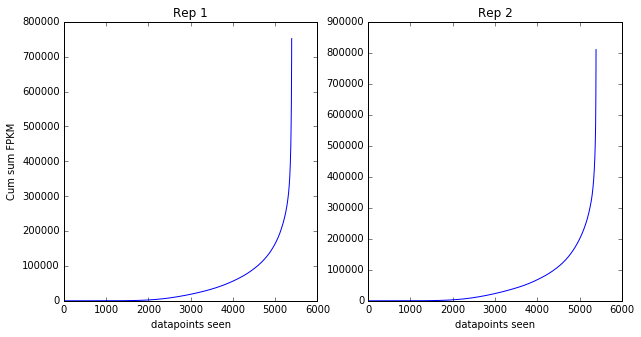

In [14]:
plot_cumsum_replicates(nozero_reps[rep1], nozero_reps[rep2], 'FPKM')

## Correlations of log2 transformed data with zero values in either replicate removed

In [15]:
logrep = numpy.log2(nozero_reps)

logrep_scores = score_replicates(reps, rep1, rep2, logrep)
pandas.DataFrame(logrep_scores)

,0
total rows,69690.000000
passed filter,5391.000000
Pearson,0.521577
Spearman,0.633321


But wait there's still another filter!

# Rafa's QC R script in python

In addition to being used for Rafa's MA metric, he also applies the filter below to the correlation metrics. (In addition to throwing out all rows with a zero measurement). The default $A_{cutoff}$ is 0.

$\frac{log_2(rep1) + log_2(rep2)}{2} < A_{cutoff}$

In [16]:
def MAD(reps, rep1, rep2):
    Acutoff = 0

    M = reps[rep1] - reps[rep2]
    A = (reps[rep1] + reps[rep2]) / 2.0

    cutrep = reps[A > Acutoff]

    mad_score = numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3)
    sd_score = numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3)

    cutrep_scores = score_replicates(reps, rep1, rep2, cutrep)
    cutrep_scores['MAD of log ratios'] = mad_score
    cutrep_scores['SD of log ratios'] = sd_score
    return pandas.DataFrame(cutrep_scores)

MAD(logrep, rep1, rep2)

,0
total rows,5391.000000
passed filter,4029.000000
Pearson,0.421687
Spearman,0.608394
MAD of log ratios,1.526000
SD of log ratios,3.199000


# Rafa's QC R script run through rpy

Rafa's script requires the replicate names are rep1 and rep2, I was using library accession numbers so we need to switch the column names.

In [17]:
colnames = reps.columns
Acutoff = 0

In [18]:
reps.columns=['rep1', 'rep2']
%Rpush reps Acutoff

In [19]:
%%R
nozero <- which(reps$rep1 != 0 | reps$rep2 != 0)
reps_part <- reps[nozero,]
logrep1 <- log2(reps$rep1[nozero])
logrep2 <- log2(reps$rep2[nozero])
A <- (logrep1 + logrep2) / 2
M = logrep1 - logrep2

cat("\"MAD of log ratios\":", round(median(abs(M)[A>Acutoff])*1.4826,3),",","\n")
cat("\"Pearson correlation\":",cor(logrep1[A>Acutoff],logrep2[A>Acutoff]),",","\n")
cat("\"Spearman correlation\":",cor(logrep1[A>Acutoff],logrep2[A>Acutoff],method="spearman"),",","\n")
cat("\"SD of log ratios\":", round(sqrt(mean(M[A>Acutoff]^2)),3),"\n")

"MAD of log ratios": 1.526 , 
"Pearson correlation": 0.4216871 , 
"Spearman correlation": 0.6083939 , 
"SD of log ratios": 3.199 


Put our column names back.

In [20]:
reps.columns = colnames

# What fails threshold?

I had trouble visualizing what data was being tossed because of the $A > A_{cutoff}$ threshold. The next two plots are my attempt to visualize the $A_{cutoff}$ threshold.

## Scatter plot of log2 transformed filtered data

The scatter plot below is the $log_2$ transformed data with all rows with a zero in either replicate removed. Additionally values below the $A > A_{cutoff}$ threshold are colored red, the spike ins are colored yellow.

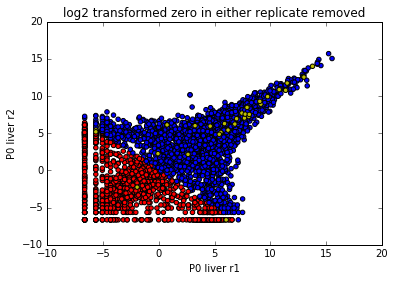

In [21]:
plt.title("log2 transformed zero in either replicate removed")
plt.xlabel(tissue_13pg_labels[rep1])
plt.ylabel(tissue_13pg_labels[rep2])
colors = []
A = (logrep[rep1] + logrep[rep2]) / 2.0
for i, average in enumerate(A):
    if A.index[i].startswith('gSpike'):
        colors.append('y')
    elif average < Acutoff:
        colors.append('r')
    else:
        colors.append('b')
        
_ = plt.scatter(logrep[rep1], logrep[rep2], c=colors)

# Plot ERCC spikes

n is the number of spikes that pass all the thresholds (Bonus plot because it was hard to see the spikes in the full dataset.)

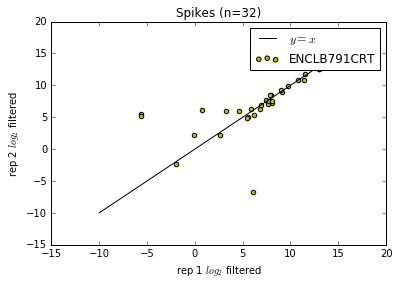

In [22]:
plot_spikes(logrep[rep1], logrep[rep2])

## Histogram of log2 transformed data with rows with zeros in either replicate removed

The following plot is a histogram of the $log_2$ transformed data with all rows where either replicate had a zero removed. The red line represents where $A_{cutoff}$ is being applied.

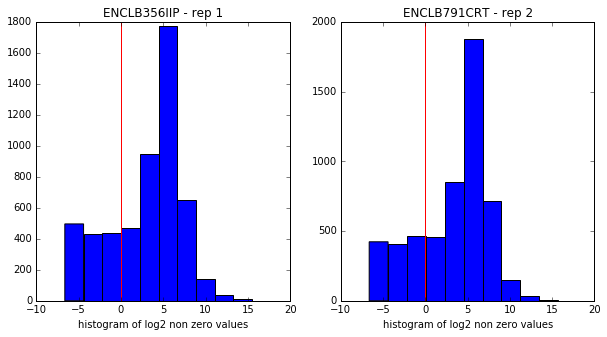

In [23]:
f = plt.figure("12", figsize=(10,5))
plt.subplot("121")
plt.title(rep1 + " - rep 1")

plt.xlabel("histogram of log2 non zero values")
_ = plt.hist(logrep[rep1])
ymin, ymax = plt.ylim()
plt.vlines(Acutoff, ymin, ymax, color='r')

plt.subplot("122")
plt.title(rep2 + " - rep 2")
plt.xlabel("histogram of log2 non zero values")
plt.hist(logrep[rep2])
ymin, ymax = plt.ylim()
_ = plt.vlines(Acutoff, ymin, ymax, color='r')


# 10ng e11.5 liver

## Correlation of 10 ng e11.5 Liver FPKMS

In [24]:
goodrep1 = 'ENCLB055KYV'
goodrep2 = 'ENCLB357KYA'
good_scores = score_replicates(tissue_10ng_fpkms, goodrep1, goodrep2, None)
pandas.DataFrame(good_scores)


,0
total rows,69690.000000
passed filter,69690.000000
Pearson,0.989209
Spearman,0.938736


## Correlation of log 2 10ng e11.5 transformed with no zeros

In [25]:
good_nozero = (tissue_10ng_fpkms[goodrep1] == 0) | (tissue_10ng_fpkms[goodrep2] == 0)

log_good = numpy.log2(tissue_10ng_fpkms[good_nozero != True])
log_good_scores = score_replicates(tissue_10ng_fpkms, goodrep1, goodrep2, log_good)
pandas.DataFrame(log_good_scores)

,0
total rows,69690.000000
passed filter,20530.000000
Pearson,0.980754
Spearman,0.988266


## Rafa's QC algorithm on the e11.5 10ng library

In [26]:
Acutoff = 0

M = log_good[goodrep1] - log_good[goodrep2]
A = (log_good[goodrep1] + log_good[goodrep2]) / 2.0

cut_good = log_good[A > Acutoff]

print("MAD of log ratios: ", numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3))
print("SD of log ratios:", numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3))

cut_good_scores = score_replicates(tissue_10ng_fpkms, goodrep1, goodrep2, cut_good)
pandas.DataFrame(cut_good_scores)

MAD of log ratios:  0.188
SD of log ratios: 0.287


,0
total rows,69690.000000
passed filter,13198.000000
Pearson,0.991193
Spearman,0.992050


# Scatter plot of log2 tranformed pyramidal neurons with zeros in either replicate removed

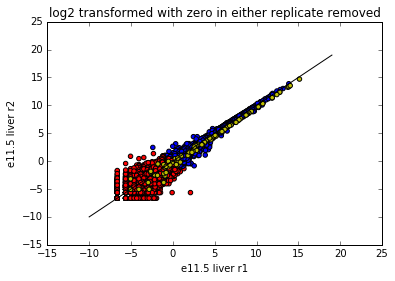

In [27]:
plt.title("log2 transformed with zero in either replicate removed")
plt.xlabel(tissue_10ng_labels[goodrep1])
plt.ylabel(tissue_10ng_labels[goodrep2])
colors = []

for i, average in enumerate(A):
    if A.index[i].startswith('gSpike'):
        colors.append('y')
    elif average < Acutoff:
        colors.append('r')
    else:
        colors.append('b')

_ = plt.scatter(log_good[goodrep1], log_good[goodrep2], c=colors)
xlim = plt.xlim()
xmin, xmax = int(xlim[0]), int(xlim[1])
_ = plt.plot(range(xmin, xmax), range(xmin, xmax), 'k')

# spikes log2 transformed no zeros

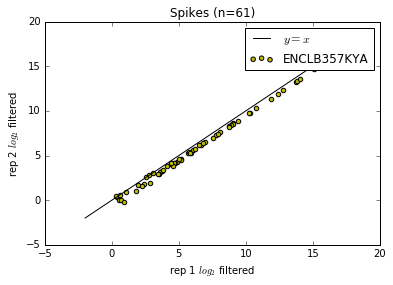

In [28]:
plot_spikes(cut_good[goodrep1], cut_good[goodrep2])

# Conclusion

With the less good library, we started with 69,690 RSEM FPKM rows and after the combination of dropping either column with a zero and tossing all rows where the average of the $log_2$ transformed FPKM scores of the two replicates was below zero, we ended with only 4,029 rows.

With the better library we started with 69,690 gene ids and ended with 12,647 rows that passed the threshold.

Additionally the spike-ins look much more stable. There are 96 possible spike ins, the poor quality library had 32 that passed the strict A threshold, and and the better library had 48 that were still included.

## Poor library

In [29]:

#cutrep = logrep[A > Acutoff]
pandas.DataFrame({'naive': naive_scores,
                  'both zero': bothzero_score,
                  'no zeros': nozero_scores,
                  'log': logrep_scores,
                 # 'Acutoff': cutrep_scores,
                 },
                 columns = ['naive', 'both zero', 'no zeros', 'log',]# 'Acutoff',]
                 )


,naive,both zero,no zeros,log
total rows,69690.000000,69690.000000,69690.000000,69690.000000
passed filter,69690.000000,10601.000000,5391.000000,5391.000000
Pearson,0.949737,0.949396,0.949233,0.521577
Spearman,0.655810,0.305444,0.633321,0.633321


## Better Library

In [30]:
pandas.DataFrame({'naive good': good_scores,
                  'log good': log_good_scores,
                  'Acutoff good': cut_good_scores},
                 columns=['naive good', 'log good', 'Acutoff good'])

,naive good,log good,Acutoff good
total rows,69690.000000,69690.000000,69690.000000
passed filter,69690.000000,20530.000000,13198.000000
Pearson,0.989209,0.980754,0.991193
Spearman,0.938736,0.988266,0.992050


# Compare Naive Pearson with large outlier

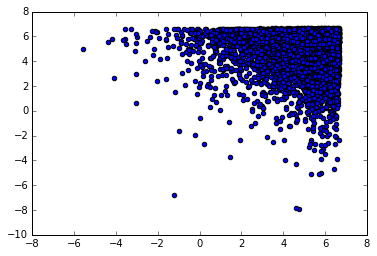

In [31]:
x = pandas.DataFrame(numpy.log2(numpy.random.rand(10000,2)*100), columns=['rep1', 'rep2'])

plt.scatter(x['rep1'], x['rep2'])

In [32]:
MAD(x, 'rep1', 'rep2')

,0
total rows,10000.000000
passed filter,9987.000000
Pearson,-0.001893
Spearman,-0.008324
MAD of log ratios,1.474000
SD of log ratios,2.019000


In [33]:
x['rep1'][9999] = numpy.log2(100) + x['rep1'][9999]
x['rep2'][9999] = 0 + x['rep2'][9999]

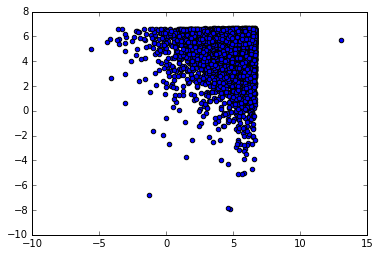

In [34]:
plt.scatter(x['rep1'], x['rep2'])

In [35]:
MAD(x, 'rep1', 'rep2')

,0
total rows,10000.000000
passed filter,9987.000000
Pearson,-0.001737
Spearman,-0.008322
MAD of log ratios,1.475000
SD of log ratios,2.020000


In [36]:
noise = pandas.DataFrame(numpy.log2(numpy.random.rand(10000,2)*100), columns=['rep1', 'rep2'])
good = pandas.DataFrame([ (x,x) for x in numpy.log2(numpy.random.rand(10000)*100) ], columns=['rep1', 'rep2'])
x = pandas.concat([noise,good])

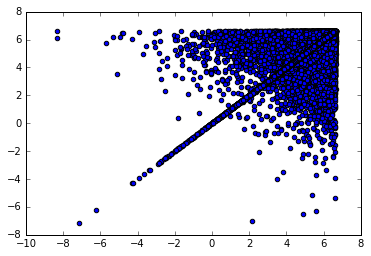

In [37]:
plt.scatter(x['rep1'], x['rep2'])

In [38]:
MAD(x, 'rep1', 'rep2')

,0
total rows,20000.000000
passed filter,19889.000000
Pearson,0.455496
Spearman,0.499924
MAD of log ratios,0.010000
SD of log ratios,1.424000


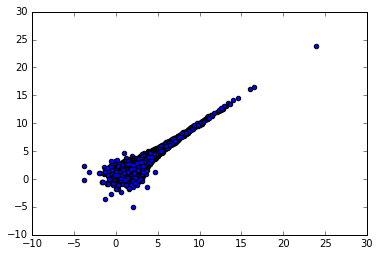

In [39]:
noise = numpy.random.normal(loc=0.0, scale=1, size=(10000, 2))
values = numpy.random.lognormal(mean=1.0, sigma=0.5, size=(10000))
x = pandas.DataFrame(
    [ (v + (n[0]/v), v + (n[1]/v)) for v, n in zip (values, noise) ],
    columns=['rep1', 'rep2'])
plt.scatter(x['rep1'], x['rep2'])

In [40]:
score_replicates(x, 'rep1', 'rep2', None)

total rows       10000.000000
passed filter    10000.000000
Pearson              0.926145
Spearman             0.882904
dtype: float64

In [41]:
MAD(x, 'rep1', 'rep2')

,0
total rows,10000.000000
passed filter,9947.000000
Pearson,0.928270
Spearman,0.881422
MAD of log ratios,0.494000
SD of log ratios,0.642000


In [42]:
x = pandas.concat([x, 
                   pandas.DataFrame(numpy.zeros(shape=(5000,2)), 
                                    columns=['rep1', 'rep2'])])
display(score_replicates(x, 'rep1', 'rep2', None))
display(MAD(x, 'rep1', 'rep2'))

total rows       15000.000000
passed filter    15000.000000
Pearson              0.964721
Spearman             0.951073
dtype: float64

,0
total rows,15000.000000
passed filter,9947.000000
Pearson,0.928270
Spearman,0.881422
MAD of log ratios,0.494000
SD of log ratios,0.642000


In [44]:
x = pandas.concat([x, 
                   pandas.DataFrame(numpy.ones(shape=(5,2))*10000, 
                                    columns=['rep1', 'rep2'])])
display(score_replicates(x, 'rep1', 'rep2', None))
display(MAD(x, 'rep1', 'rep2'))

total rows       15005.000000
passed filter    15005.000000
Pearson              0.999996
Spearman             0.951124
dtype: float64

,0
total rows,15005.000000
passed filter,9952.000000
Pearson,0.999996
Spearman,0.881601
MAD of log ratios,0.494000
SD of log ratios,0.642000
